In [2]:
import numpy as np
import h5py
import halotools
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname = 'bolplanck', version_name = 'halotools_v0p4',redshift = 0, \
                            halo_finder = 'rockstar')

In [6]:
mask = np.logical_and(halocat.halo_table['halo_mvir']>4e14,halocat.halo_table['halo_upid']==-1)

In [7]:
halo_x = halocat.halo_table['halo_x'][mask]
halo_y = halocat.halo_table['halo_y'][mask]
halo_z = halocat.halo_table['halo_z'][mask]

center = np.zeros((len(halo_x),3))

center[:,0] = halo_x
center[:,1] = halo_y
center[:,2] = halo_z

In [8]:
center.shape

(29, 3)

In [9]:
with h5py.File('/home/kuw8/.astropy/cache/halotools/particle_catalogs/bolplanck/hlist_1.00231.particles.halotools_v0p4.hdf5', 'r') as f:
    ptcl_array = f['data'][()]
ptclpos = np.zeros((len(ptcl_array),3))
ptclpos[:,0] = ptcl_array['x']
ptclpos[:,1] = ptcl_array['y']
ptclpos[:,2] = ptcl_array['z']

In [10]:
ptclpos.shape

(1000000, 3)

In [11]:
from fast3tree import fast3tree, get_distance

def get_binned_profiles(particles_pos, halos_pos, bins, box_size):
    """
    Parameters
    ----------
    particles_pos : M-by-3 2d numpy array
    halos_pos : N-by-3 2d numpy array
    bins : sorted 1d array
    box_size : float
    
    Returns
    -------
    binned_profiles : N-by-len(bins) numpy array
    """
    assert (np.ediff1d(bins) > 0).all()
    max_r = bins[-1]
    nbins = len(bins)
    binned_profiles = []
    with fast3tree(particles_pos) as tree:
        tree.set_boundaries(0, box_size)
        for halo_pos in halos_pos:
            pos = tree.query_radius(halo_pos, max_r, True, 'pos')
            pos = get_distance(halo_pos, pos, box_size)
            pos = np.searchsorted(bins, pos, 'right')
            pos = np.bincount(pos, minlength=nbins)[:nbins]
            binned_profiles.append(pos)
            print '*'
    return np.array(binned_profiles)

In [12]:
binned_profiles = get_binned_profiles(ptclpos,center,np.linspace(0,3.5,350),500)

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


### binned_profiles contains dN/dr for each halo(not normalized)

In [13]:
binned_profiles.shape

(29, 350)

In [14]:
dndr = binned_profiles[:,1:]/(np.linspace(0,3.5,350)[1:]**2)

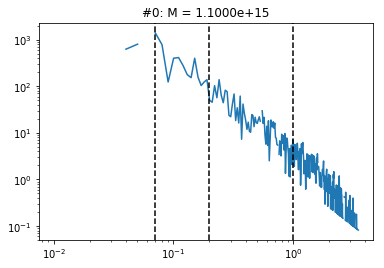

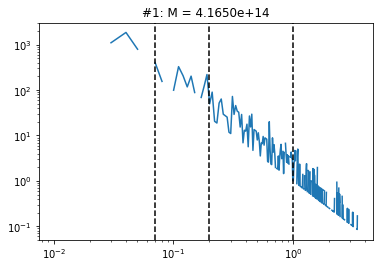

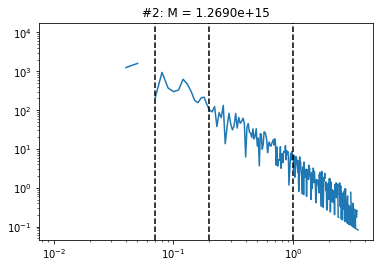

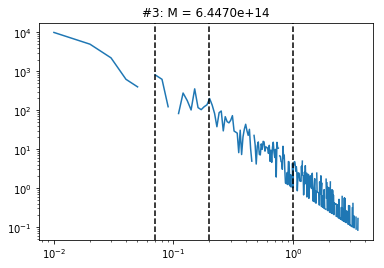

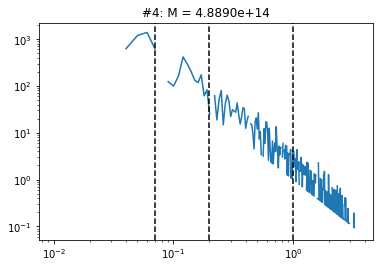

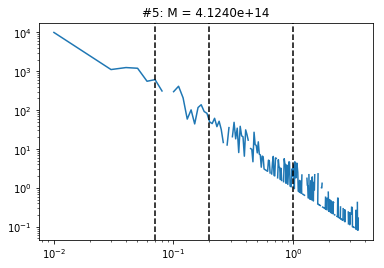

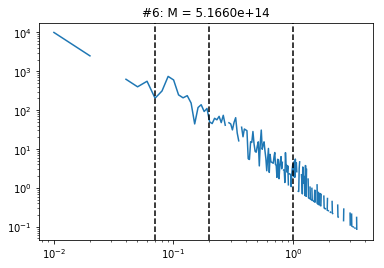

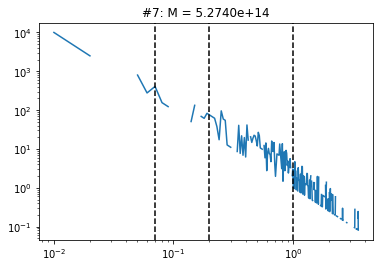

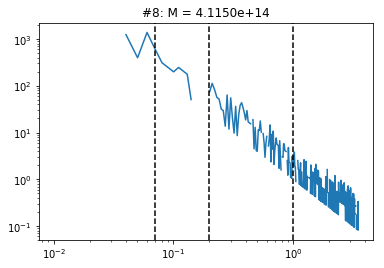

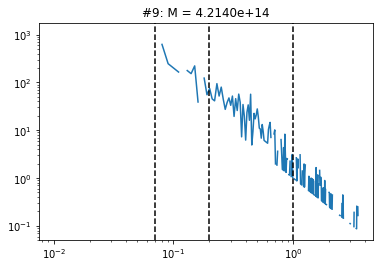

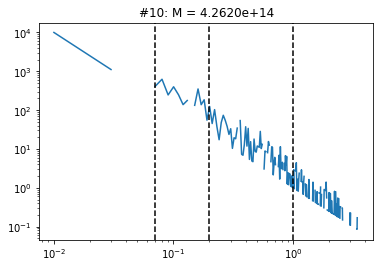

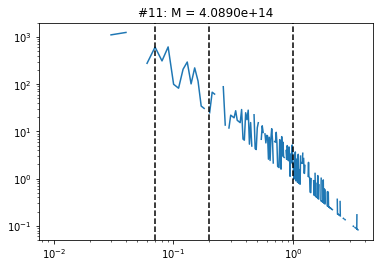

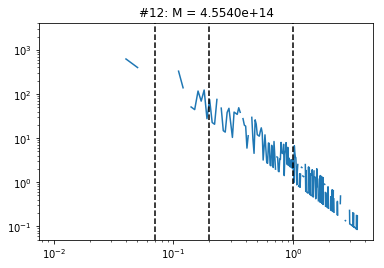

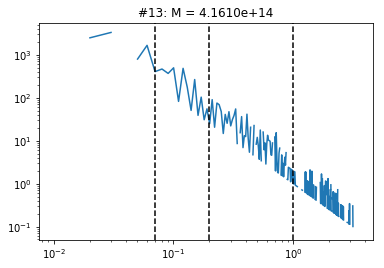

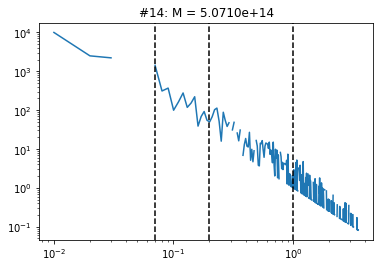

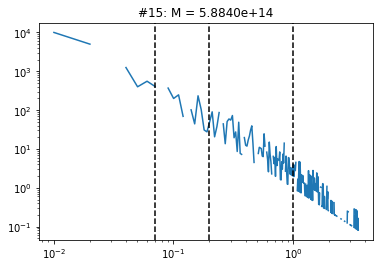

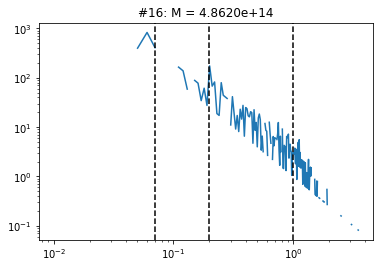

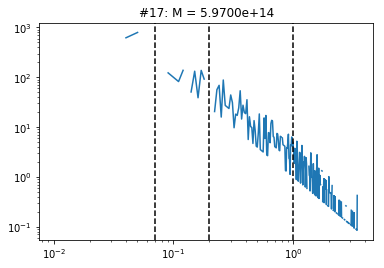

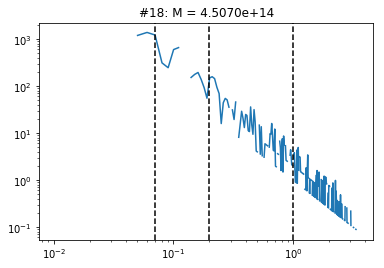

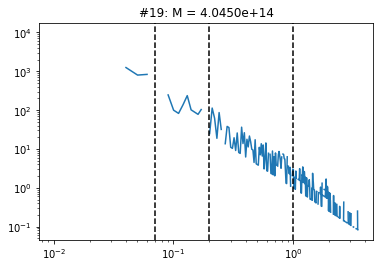

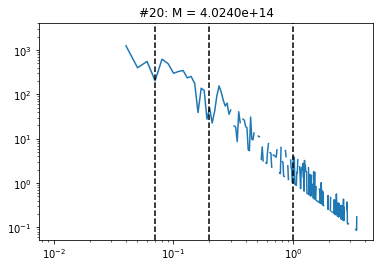

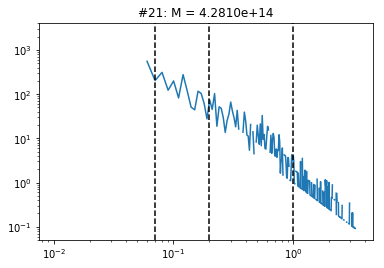

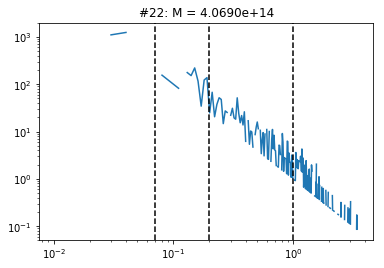

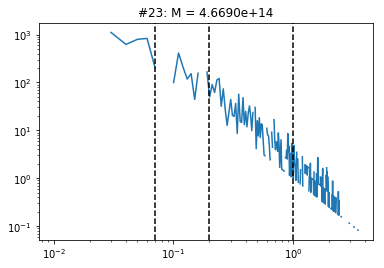

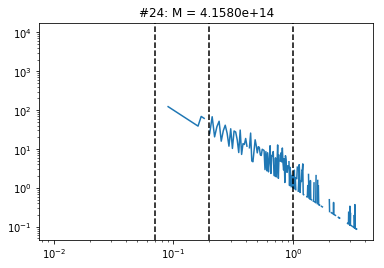

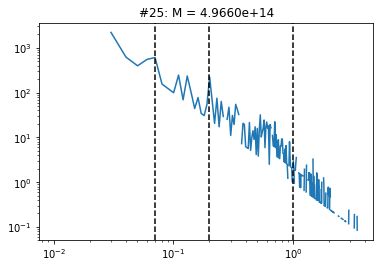

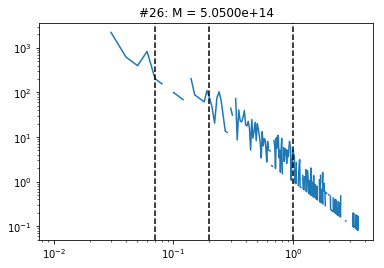

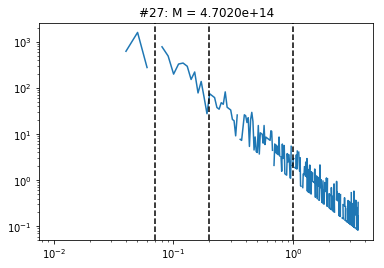

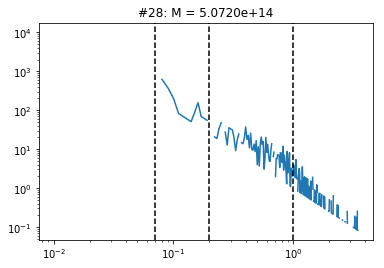

In [16]:
for i in range(29):
    plt.figure()
    plt.plot(np.linspace(0,3.5,350)[1:],dndr[i])
    plt.axvline(x=0.07,linestyle='--',color='k')
    plt.axvline(x=0.2,linestyle='--',color='k')
    plt.axvline(x=1,linestyle='--',color='k')
    plt.loglog()
    plt.title('#%i: M = %.4e'%(i,halocat.halo_table['halo_mvir'][mask][i]))

### M_ptcl = resolution\*downsampling factor = 8.7e9*10 = 8.7e10

In [17]:
print np.sort(np.array(halocat.halo_table['halo_rvir'][mask]))

[ 1.50083995  1.50341797  1.50631797  1.50888193  1.51204598  1.51307392
  1.51724303  1.51769495  1.51813304  1.52402401  1.52985096  1.53211308
  1.55855298  1.56395602  1.57707202  1.58074498  1.59849     1.60146403
  1.6097939   1.61877298  1.62106204  1.62112093  1.631163    1.64235497
  1.70346701  1.71167302  1.75607991  2.09873199  2.2010839 ]


In [20]:
print np.sum(binned_profiles,axis=1)*1.55e8*2048**3/1e6

[  1.39934329e+15   6.65719931e+14   1.68560286e+15   9.79939738e+14
   7.46937762e+14   6.29771055e+14   6.27108175e+14   7.32291924e+14
   9.82602618e+14   6.05805137e+14   6.32433934e+14   5.44558903e+14
   6.81697209e+14   6.76371450e+14   7.28297604e+14   7.53594962e+14
   5.28581625e+14   7.68240800e+14   7.10988886e+14   6.64388491e+14
   5.99147938e+14   6.63057051e+14   5.44558903e+14   6.96343048e+14
   5.31244505e+14   6.64388491e+14   6.73708570e+14   8.49458632e+14
   6.45748333e+14]


In [19]:
print np.array(halocat.halo_table['halo_mvir'][mask])

[  1.09999998e+15   4.16499991e+14   1.26900003e+15   6.44700025e+14
   4.88899986e+14   4.12400008e+14   5.16600009e+14   5.27400006e+14
   4.11500011e+14   4.21400012e+14   4.26200007e+14   4.08900013e+14
   4.55400013e+14   4.16099988e+14   5.07100011e+14   5.88399983e+14
   4.86199995e+14   5.96999984e+14   4.50700010e+14   4.04499986e+14
   4.02400016e+14   4.28099993e+14   4.06900001e+14   4.66899989e+14
   4.15800012e+14   4.96599990e+14   5.05000007e+14   4.70200000e+14
   5.07200003e+14]


In [21]:
print np.array(halocat.halo_table['halo_mvir'][mask])-np.sum(binned_profiles,axis=1)*1.55e8*2048**3/1e6

[ -2.99343316e+14  -2.49219940e+14  -4.16602835e+14  -3.35239713e+14
  -2.58037776e+14  -2.17371046e+14  -1.10508166e+14  -2.04891918e+14
  -5.71102607e+14  -1.84405125e+14  -2.06233928e+14  -1.35658891e+14
  -2.26297196e+14  -2.60271461e+14  -2.21197594e+14  -1.65194978e+14
  -4.23816300e+13  -1.71240816e+14  -2.60288876e+14  -2.59888505e+14
  -1.96747922e+14  -2.34957058e+14  -1.37658903e+14  -2.29443059e+14
  -1.15444493e+14  -1.67788501e+14  -1.68708564e+14  -3.79258631e+14
  -1.38548330e+14]


In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
%matplotlib notebook

In [25]:
def pos_visual(particles_pos, halos_pos, r=3.5, box_size=500):
    with fast3tree(particles_pos) as tree:
        tree.set_boundaries(0, box_size)
        for halo_pos in halos_pos:
            pos = tree.query_radius(halo_pos, r, True, 'pos')
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            xs = pos[:,0]
            ys = pos[:,1]
            zs = pos[:,2]
            ax.scatter(xs, ys, zs, s=0.1)
            ax.plot([halo_pos[0],],[halo_pos[1],],[halo_pos[2],],'ro')

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
    return 0

<IPython.core.display.Javascript object>


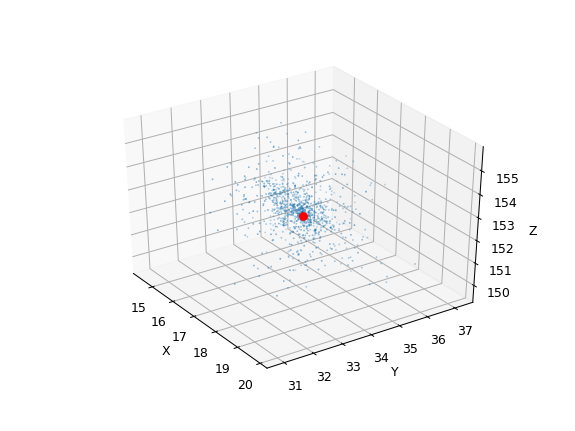

<IPython.core.display.Javascript object>


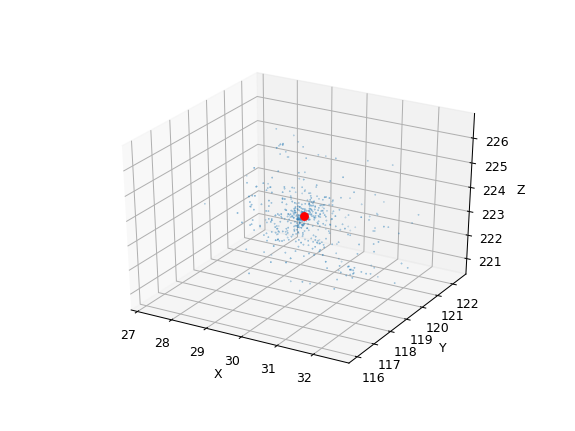

<IPython.core.display.Javascript object>


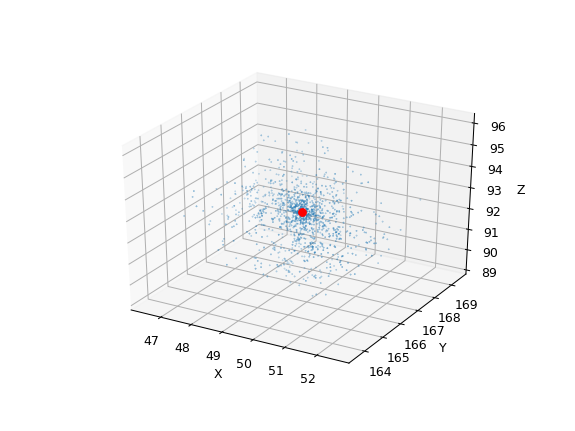

<IPython.core.display.Javascript object>


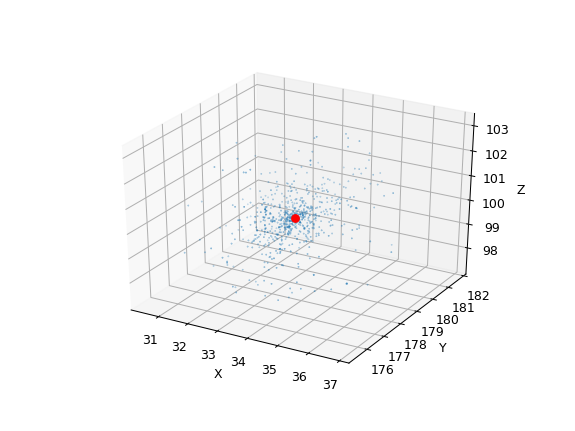

<IPython.core.display.Javascript object>


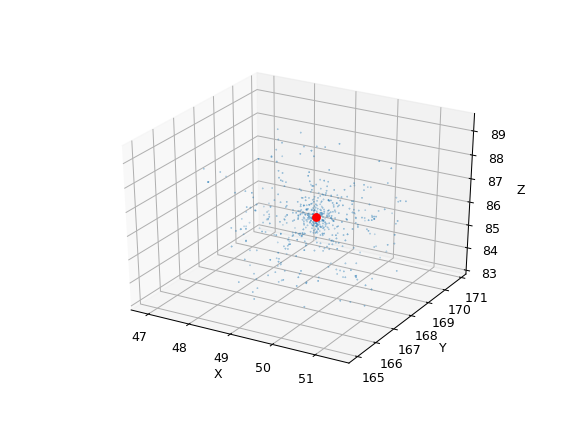

<IPython.core.display.Javascript object>


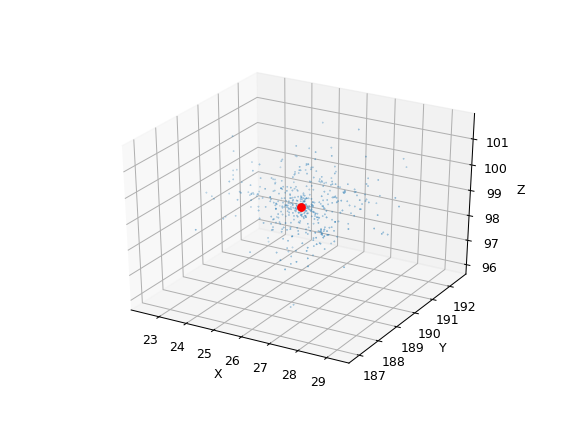

<IPython.core.display.Javascript object>


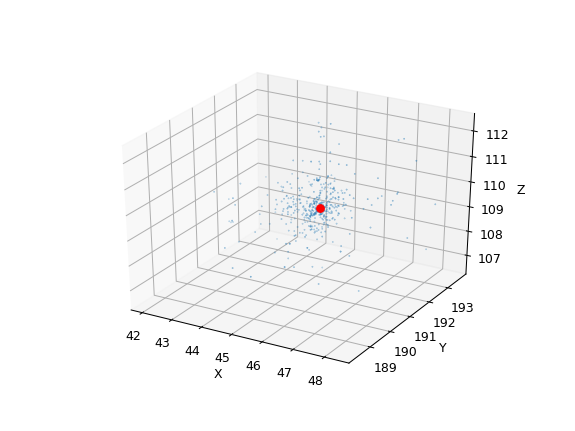

<IPython.core.display.Javascript object>


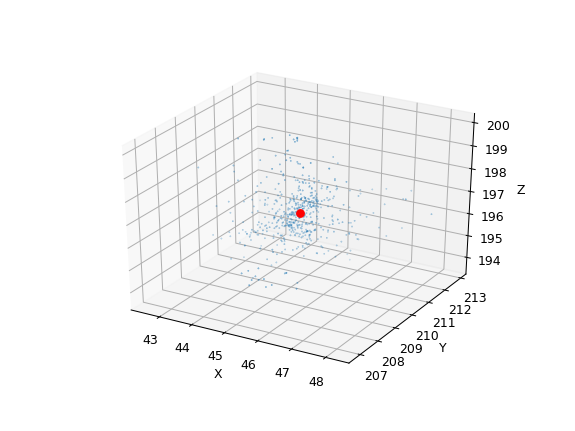

<IPython.core.display.Javascript object>


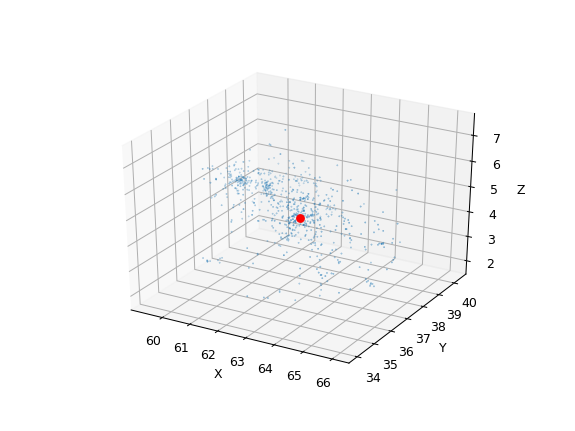

<IPython.core.display.Javascript object>


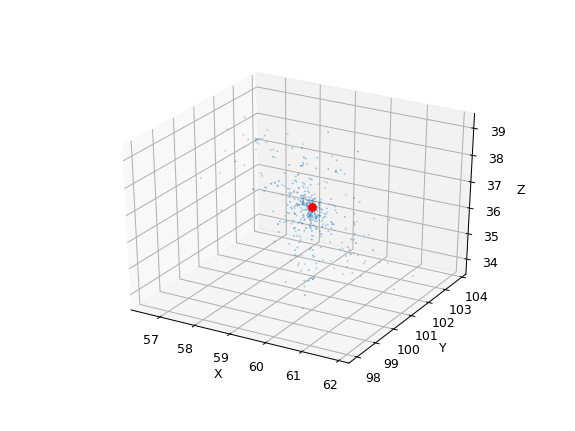

<IPython.core.display.Javascript object>


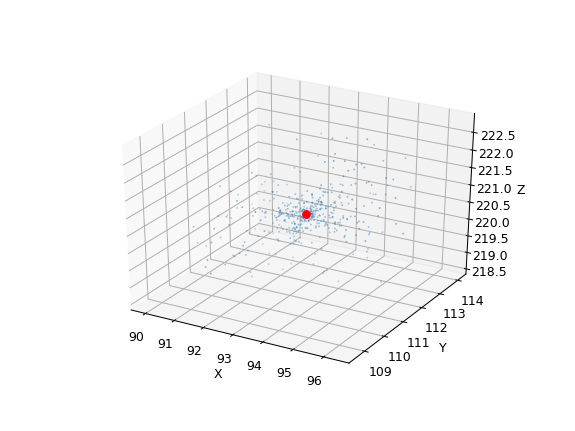

<IPython.core.display.Javascript object>


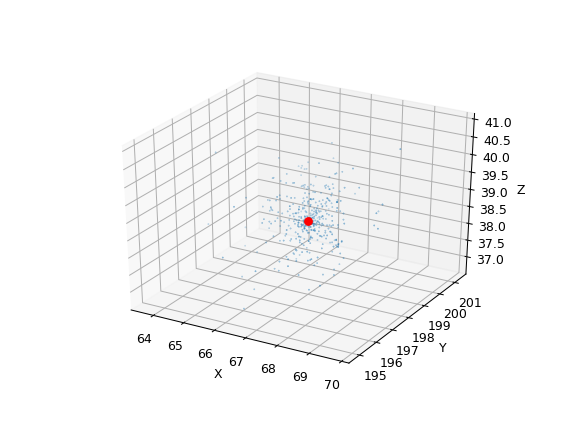

<IPython.core.display.Javascript object>


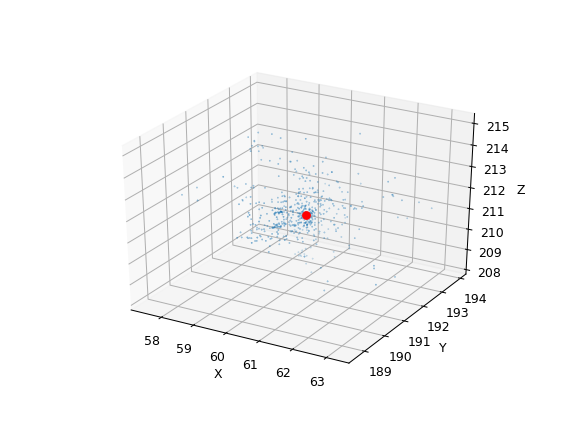

<IPython.core.display.Javascript object>


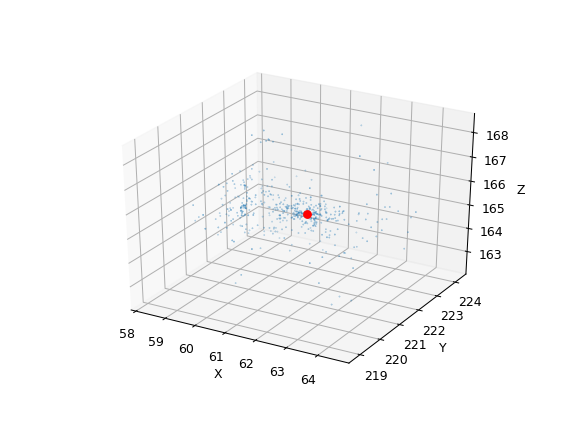

<IPython.core.display.Javascript object>


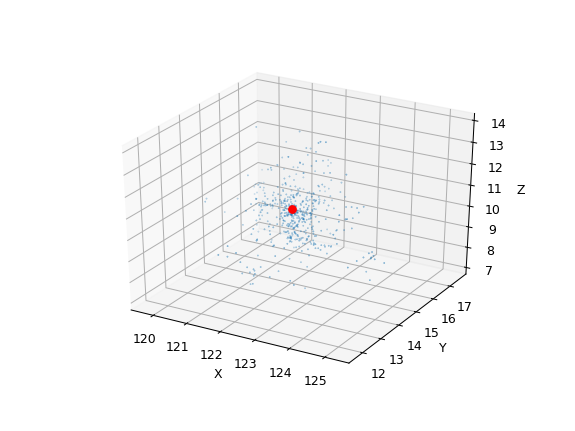

<IPython.core.display.Javascript object>


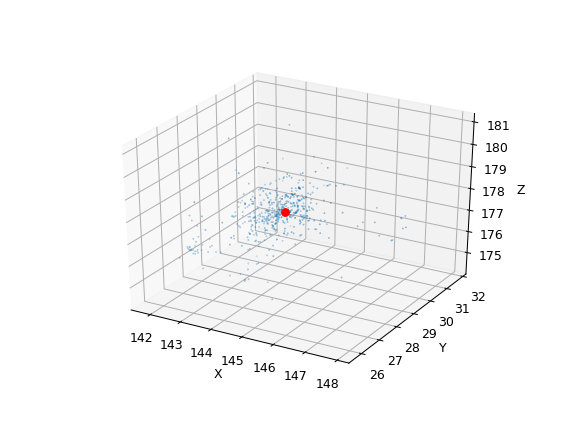

<IPython.core.display.Javascript object>


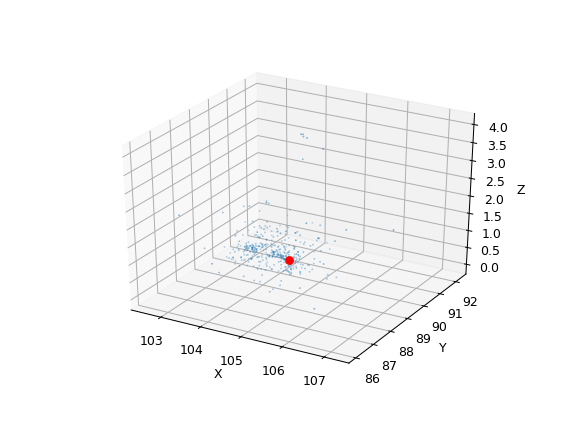

<IPython.core.display.Javascript object>


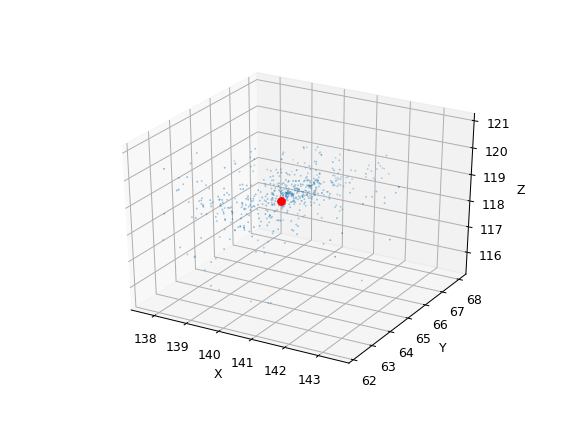

<IPython.core.display.Javascript object>


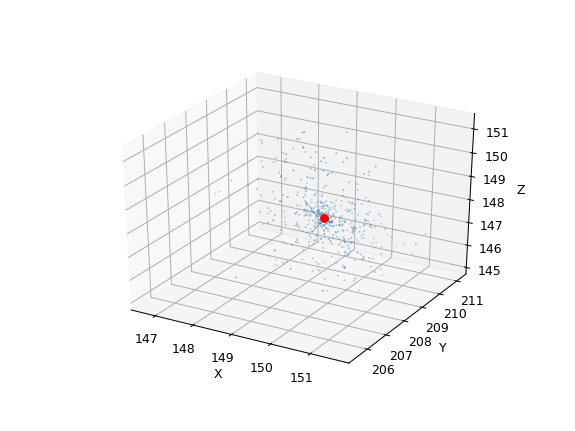

<IPython.core.display.Javascript object>


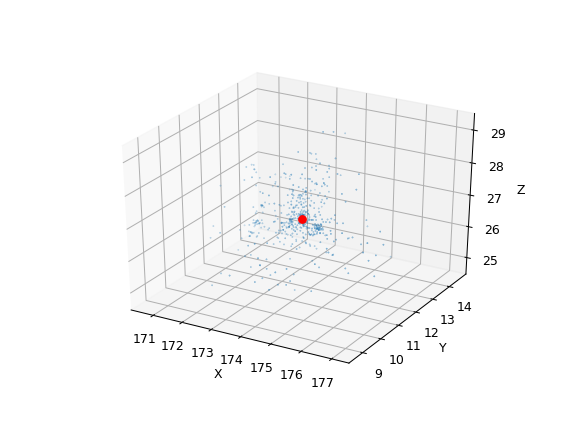

<IPython.core.display.Javascript object>


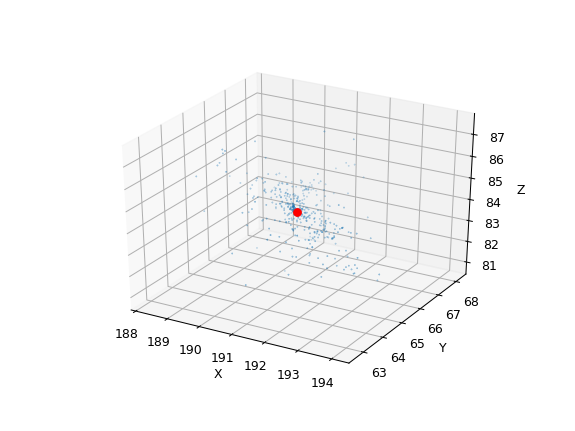

<IPython.core.display.Javascript object>


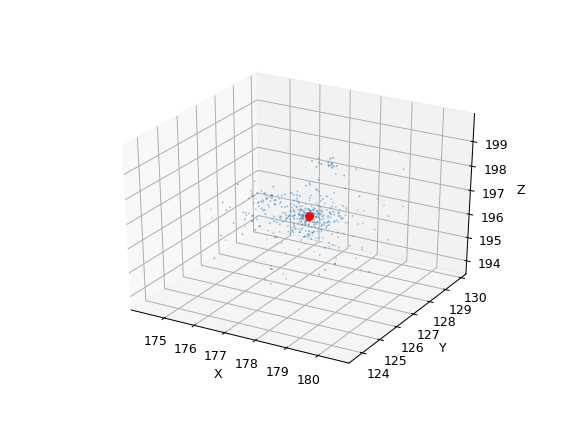

<IPython.core.display.Javascript object>


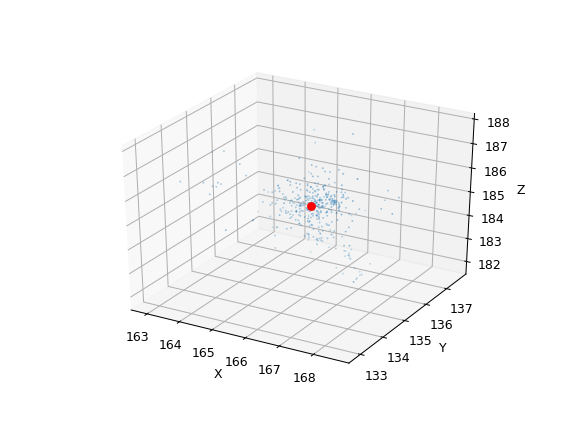

<IPython.core.display.Javascript object>


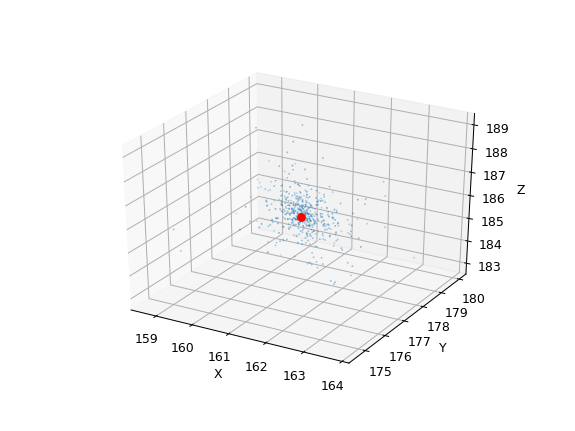

<IPython.core.display.Javascript object>


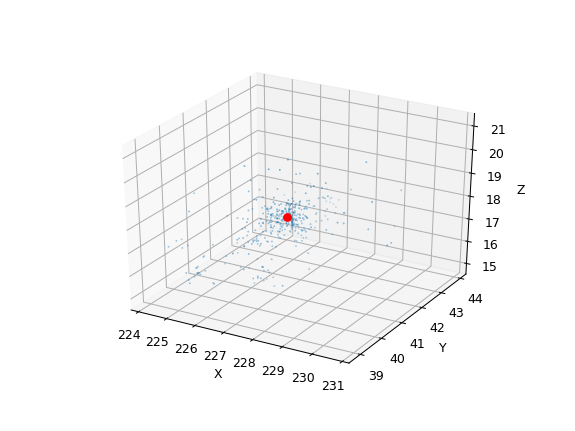

<IPython.core.display.Javascript object>


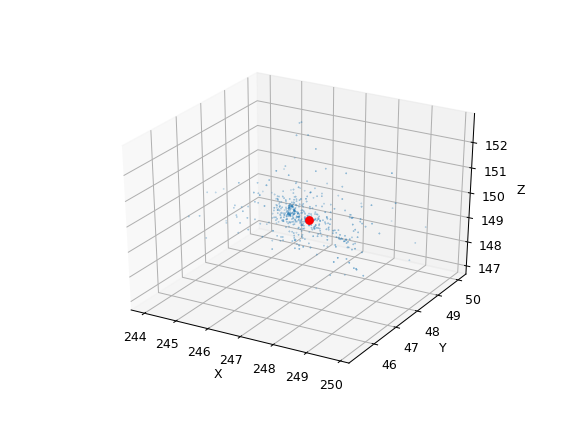

<IPython.core.display.Javascript object>


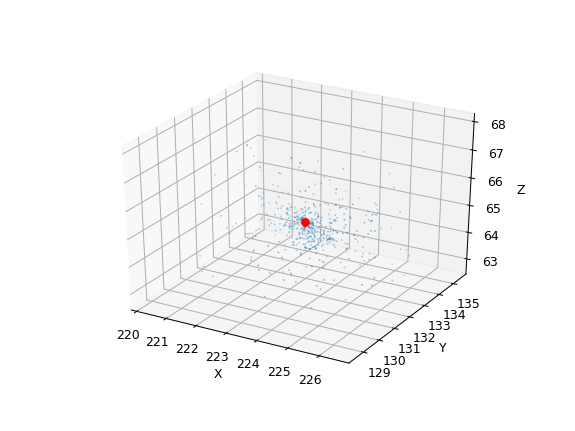

<IPython.core.display.Javascript object>


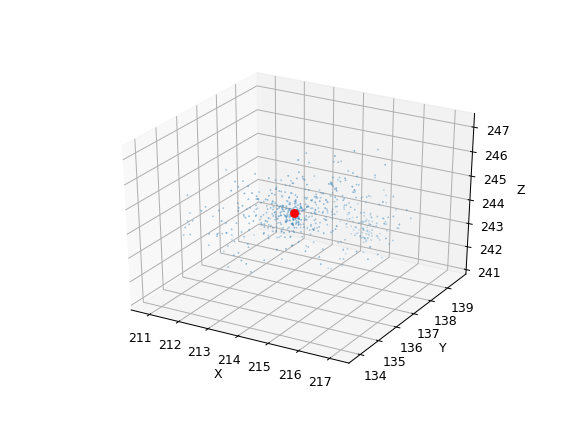

<IPython.core.display.Javascript object>


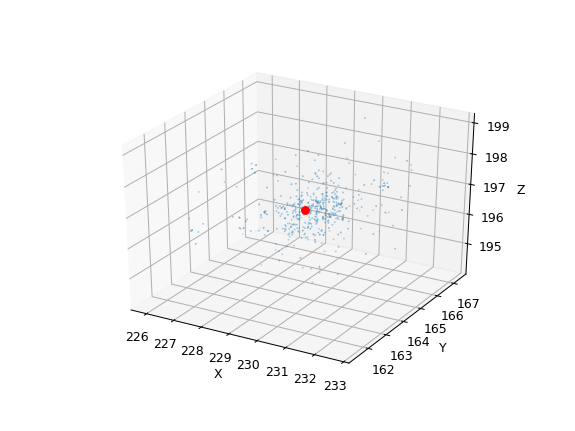

0

In [26]:
pos_visual(ptclpos,center)